## NB6. Mapping ocean basins based on river network used for CTSM/CESM case(s) <a id='top'></a>

Use 

1. reach-D19 gauge link ascii
2. D19 flow site point geopackage
3. ocean polygon geopackage
4. catchment polygon geopackage
5. outlet reach information (netCDF)

[1. Setupt](#setup)

[2. Read river, catchment, gauge information](#read_meta)

- xxx

[4. Maps](#maps)

- Ocean and outlet catchments.


In [1]:
%matplotlib inline

import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scripts.utility import load_toml 
from scripts.utility import no_time_variable
from scripts.utility import read_shps

print("\nPython version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)
print(gpd.__name__, gpd.__version__)


Python version: 3.10.12
xarray 2023.6.0
pandas 2.0.3
geopandas 0.13.2


In [2]:
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
land = cfeature.LAND

-------------------------
## 1. Analysis setup <a id='setup'></a>

**Please provide river network names**

[go back to top](#top)

In [3]:
network_list = ['HDMA_lake', 'HDMA', 'MERIT_Hydro', 'mosart']

In [4]:
# CESM case names and their runoff grid

network = 'HDMA'

-------------------------
load config files and some parameters 

In [5]:
setup = load_toml('./setup/setup.toml')

main_dir       = setup['archive_dir']     # CESM archive directory
domain_dir     = setup['ancillary_dir']   # ancillary directory including such as ROF domain
ref_flow_dir   = setup['ref_flow_dir']    # including observed or reference flow data
geospatial_dir = setup['geospatial_dir']  # including shapefiles etc

rof_grid       = setup['rof_grid']        # RO grid meta
catch_gpkg     = setup['catch_gpkg']
reach_gpkg     = setup['reach_gpkg']      # reach geopackage meta
network_nc     = setup['river_network']

In [6]:
oceans_list = ['arctic', 'atlantic', 'indian', 'mediterranean', 'pacific', 'south_china', 'global']

In [7]:
save_gpkg=False

## 3. Reading river, catchment, gauge infomation  <a id='read_meta'></a>

- gauge-catchment link (csv)
- gauge point (geopackage)
- ocean polygon (geopackage)
- catchment polygon (geopackage)
- outlet reach information (netCDF)

[go back to top](#top)

### 3.1. reach-D19 gauge link csv
- creating gauge_reach_lnk (dataframe)

In [8]:
gauge_reach_lnk = pd.read_csv('%s/D09/D09_925.%s.asc'%(ref_flow_dir, network))
if network=='mosart':
    # temporal fix for f09_f09_mg17 run (simulation use 0 360 grid, but gauge-reach link use -180 180 grid
    gauge_reach_lnk.loc[gauge_reach_lnk['gauge_lon']<0, 'route_id' ] = gauge_reach_lnk['route_id'] + 360
    gauge_reach_lnk.loc[gauge_reach_lnk['gauge_lon']>0, 'route_id' ] = gauge_reach_lnk['route_id'] - 360

### 3.2 D19 flow site geopackage
- creating gauge_shp (dataframe)

In [9]:
%%time

gauge_shp = gpd.read_file(os.path.join(ref_flow_dir, 'D09','geospatial','D09_925.gpkg'))
gauge_shp = gauge_shp[gauge_shp['id']!=9999999]

CPU times: user 194 ms, sys: 7.63 ms, total: 201 ms
Wall time: 232 ms


### 3.3 Ocean geopackage
- creating ocean_shp (dataframe)

In [10]:
%%time

ocean_shp = gpd.read_file(os.path.join(geospatial_dir, 'oceans.gpkg'))

CPU times: user 14.5 s, sys: 483 ms, total: 15 s
Wall time: 15.9 s


### 3.4 Read river network information
- creating riv_ocean (dataframe)

In [11]:
%%time

## read catchment geopackage
cat_gpkg = os.path.join(geospatial_dir, catch_gpkg[network]['file_name'])  # geopackage name
id_name_cat = catch_gpkg[network]['id_name']                              # reach ID in geopackage
var_list = [id_name_cat]
if 'lake' in network:
    var_list.append('lake')
gdf_cat = read_shps([cat_gpkg], var_list)

Finished reading /glade/campaign/cgd/tss/people/mizukami/ctsm-mizuRoute/geospatial/hdma_global_catch_v2_0.01.gpkg
CPU times: user 44.2 s, sys: 737 ms, total: 44.9 s
Wall time: 48.5 s


In [12]:
%%time

# read river outlet netcdf
riv_ocean_file = os.path.join(domain_dir, network_nc[network]['file_name'].replace('.aug.nc','.outlet.nc'))  # network netcdf name
ds_rn_ocean = xr.open_dataset(riv_ocean_file).set_index(seg='seg_id')
riv_ocean = ds_rn_ocean.to_dataframe()
riv_ocean = pd.merge(gdf_cat, riv_ocean, left_on=catch_gpkg[network]['id_name'], right_index=True)

CPU times: user 1.53 s, sys: 228 ms, total: 1.76 s
Wall time: 1.96 s


##### ------
## 3. Maps <a id='maps'></a>

- ocean basins

[go back to top](#top)

arctic
atlantic
indian
mediterranean
pacific
south_china
land
CPU times: user 1min 20s, sys: 627 ms, total: 1min 20s
Wall time: 1min 27s


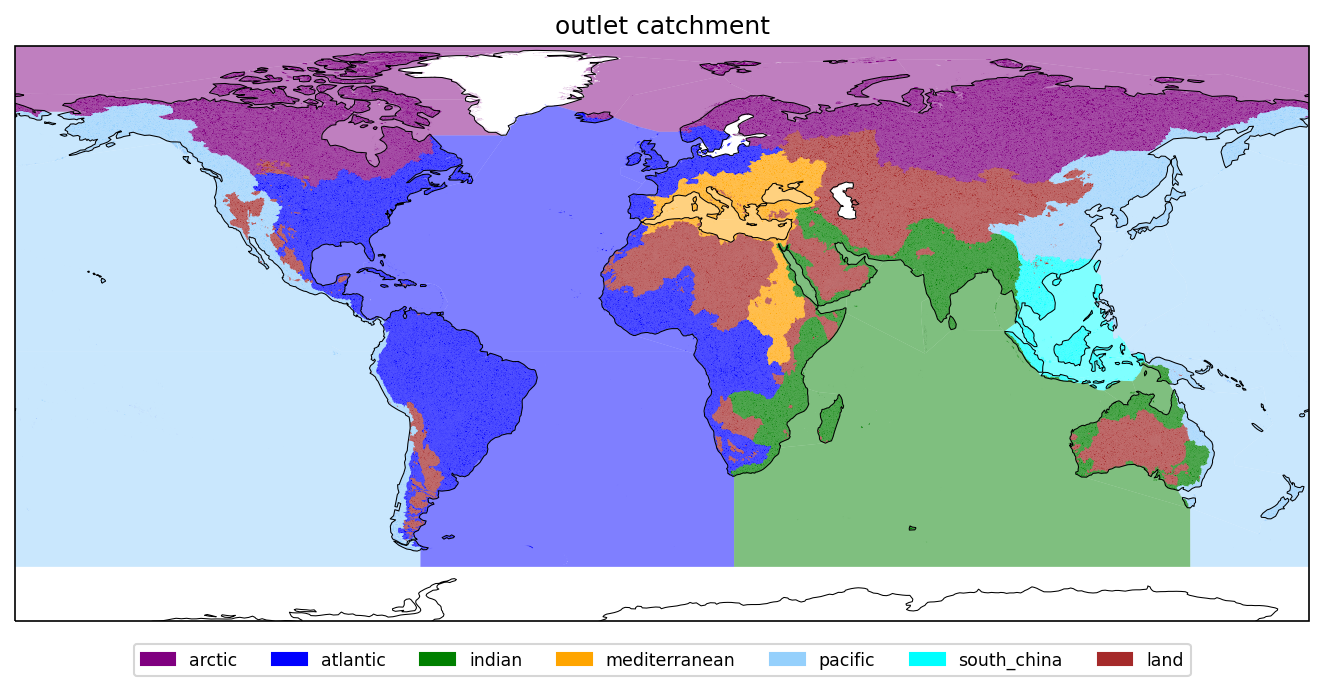

In [13]:
%%time

fig, ax = plt.subplots(1, figsize=(9.0, 5.0),subplot_kw={"projection": ccrs.PlateCarree()}, dpi=150)

cbar_kwrgs = {"shrink":0.9, "pad":0.02, "orientation": "horizontal"}

ocean_colors = {
    "arctic": "purple",
    "atlantic": "blue",
    "indian": "green",
    "mediterranean": "orange",
    "pacific": "xkcd:light blue",
    "south_china": "cyan",
    "land":"brown"
}

for ocean, color in ocean_colors.items():
    riv_ocean[riv_ocean['ocean']==ocean].plot(ax=ax, color=color)
    if ocean!='land':
        ocean_shp[ocean_shp['ocean']==ocean].plot(ax=ax, color=color, alpha=0.5)
    print(ocean)

ax.add_feature(land, facecolor="none", edgecolor='k', lw=0.5, zorder=1)
ax.set_title(f'outlet catchment')
ax.set_xlim(-180, 180)
ax.set_ylim([-75, 85])
    
patch = [mpatches.Patch(color=value, label=key) for key,value in ocean_colors.items()]
ax.legend(handles=patch, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=7, fontsize="small")

fig.tight_layout()
plt.savefig(f"./Figures/NB7_{network}_outlet.png", dpi=150)

if save_gpkg:
    riv_ocean.to_file(f"{network_name}_outlet_cat.gpkg", layer='catch', driver="GPKG")